In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Data
import numpy as np
import pandas as pd
import shutil
import time
import cv2 as cv2

#visualize
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import seaborn as sns
sns.set_style('darkgrid')
from tqdm import tqdm

import os
from glob import glob

#tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping,ModelCheckpoint
from tensorflow.keras.metrics import PrecisionAtRecall, Recall

from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from IPython.core.display import display, HTML

# stop annoying tensorflow warning messages
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

In [4]:
#put your directory here
# path = os.path.join(os.path.dirname(os.getcwd()), 'dataset') #local
path = '/content/drive/MyDrive/Assignment - Covid 19 Radiography Data/dataset' #drive

diag_code_dict = {
    'COVID': 0,
    'Lung_Opacity': 1,
    'Normal': 2,
    'Viral Pneumonia': 3}

diag_title_dict = {
    'COVID': 'Covid-19',
    'Lung_Opacity': 'Lung Opacity',
    'Normal': 'Healthy',
    'Viral Pneumonia': 'Viral Pneumonia'}

#splitext to split between imagename and imageextension
#basename is the current dir/file name
#glob to make it match everything that is indicated easily
#the output will be the name of the img:image location
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join(path, '*','*.png'))}

In [5]:
#create a dataframe
covid_df = pd.DataFrame.from_dict(imageid_path_dict, orient='index').reset_index()
covid_df.columns = ['image_id', 'image_path']
covid_df['diagram'] = covid_df['image_id'].str.split('-').str[0]
covid_df['target'] = covid_df['diagram'].map(diag_code_dict.get)
covid_df['class'] = covid_df['diagram'].map(diag_title_dict.get)

In [6]:
print(f'DataFrame shape: {covid_df.shape}')
print(f'Number of duplicated values: {covid_df.duplicated().sum()}')
print(f'Number of null samples: {covid_df.isnull().sum().sum()}')

DataFrame shape: (21167, 5)
Number of duplicated values: 0
Number of null samples: 0


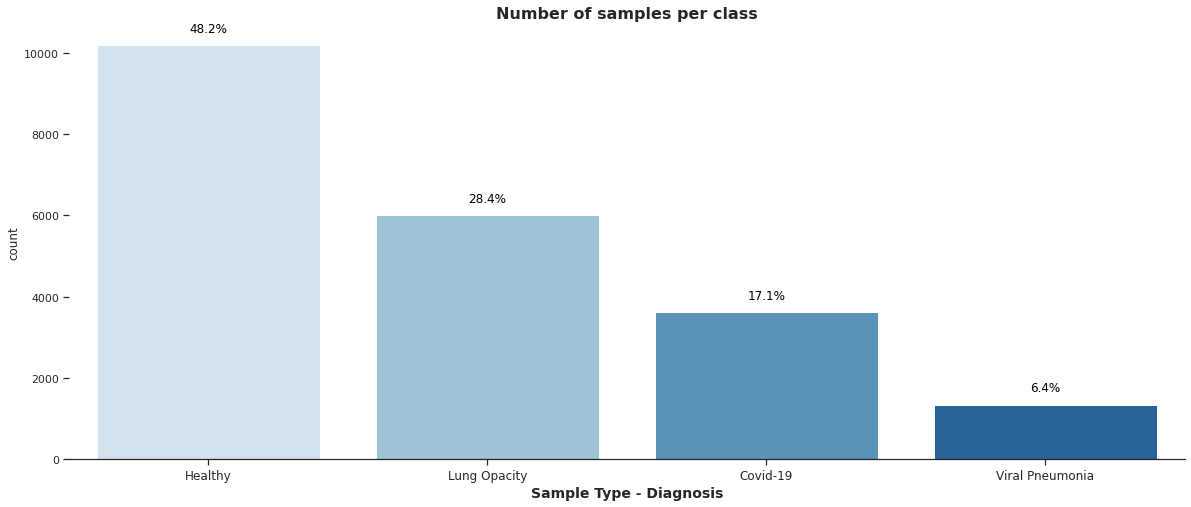

In [ ]:
plt.figure(figsize=(20,8))
sns.set(style='ticks', font_scale= 1)
# plt.style.use('fivethirtyeight')

ax = sns.countplot(data=covid_df, x='class', 
                   order=covid_df['class'].value_counts().index,
                  palette='Blues')
sns.despine(top=True, right=True, left=True, bottom=False)
plt.xticks(rotation=0, fontsize=12)
ax.set_xlabel('Sample Type - Diagnosis', fontsize=14, weight='bold')
# ax.set(yticklabels=[])
# ax.axes.get_yaxis().set_visible(False)
plt.title('Number of samples per class', fontsize=16, weight='bold')

for p in ax.patches:
    ax.annotate("%.1f%%" % (100*float(p.get_height()/covid_df.shape[0])), 
                (p.get_x() + p.get_width() / 2., abs(p.get_height())),
                ha='center', va='bottom', 
                color='black', xytext=(0, 10),
                rotation = 'horizontal',
                textcoords='offset points')

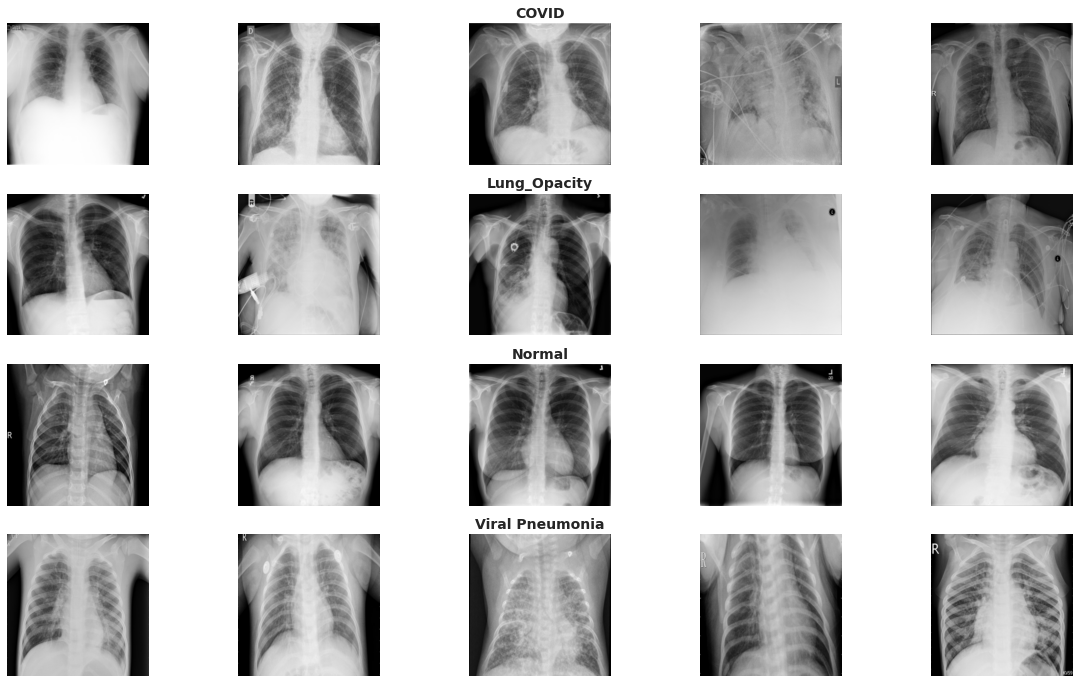

In [ ]:
#lets go more details on images data

#Image Sampling
n_samples = 5

#m_axs indicates how many rows
fig, m_axs = plt.subplots(4, n_samples, figsize = (4*n_samples, 3*4))

#group by each class
for n_axs, (class_name, class_rows) in zip(m_axs,covid_df.sort_values(['diagram']).groupby('diagram')):
    n_axs[2].set_title(class_name,fontsize = 14,weight = 'bold')
    
    #for each row/class, sample 3, and then show.
    for c_ax, (_, c_row) in zip(n_axs, class_rows.sample(n_samples, random_state=1224).iterrows()):       
        picture = c_row['image_path']
        image = cv2.imread(picture)
        c_ax.imshow(image)
        c_ax.axis('off')

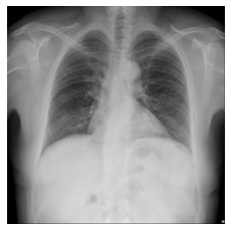

In [ ]:
#let's see the details of an image
image = cv2.imread(covid_df['image_path'][0])
plt.imshow(image)
plt.axis('off')
pass

In [ ]:
print(f'Shape of the image: {image.shape}')
print(f'Dimension of Image: {image.ndim}')
print(f'Image size: {image.size}')
print(f'Image Data Type {image.dtype}')
print(f'Maximum RGB value in this image: {image.max()}')
print(f'Minimum RGB value in this image: {image.min()}')

Shape of the image: (299, 299, 3)
Dimension of Image: 3
Image size: 268203
Image Data Type uint8
Maximum RGB value in this image: 237
Minimum RGB value in this image: 0


In [ ]:
#just for visualize purpose. This took ~2 hours
# covid_df['image'] = covid_df['image_path'].map(lambda x: np.asarray(Image.open(x).resize((60,60))))

In [ ]:
#let's see how the distribution of the value in each images 
#and each classes

image_eda = covid_df.loc[:, ['image', 'class', 'image_path']]
image_eda['mean'] = image_eda['image'].apply(lambda x: x.mean())
image_eda['stdev'] = image_eda['image'].apply(lambda x: x.std())
image_eda['min'] = image_eda['image'].apply(lambda x: x.min())

In [ ]:
# image_eda['max'] = image_eda['image'].apply(lambda x: x.max()) #dk why only max has the prob
max_ = []
min_ = []
for i in range(image_eda.shape[0]):
    max_.append(image_eda['image'][i].max())
    min_.append(image_eda['image'][i].min())

max_[0] = 214 #if no this code, the max_ go into image_eda['max'] will be very weird
image_eda['max'] = max_

In [ ]:
image_eda['max']

0        214
1        227
2        227
3        254
4        249
        ... 
21162    200
21163    231
21164    208
21165    245
21166    193
Name: max, Length: 21167, dtype: int64

Text(0.5, 1.0, 'Images Colour Min Value Distribution by Class')

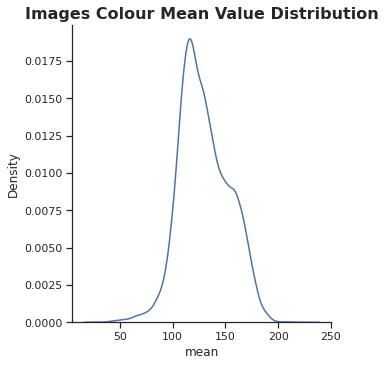

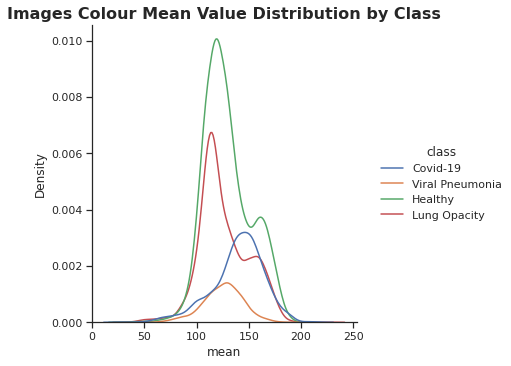

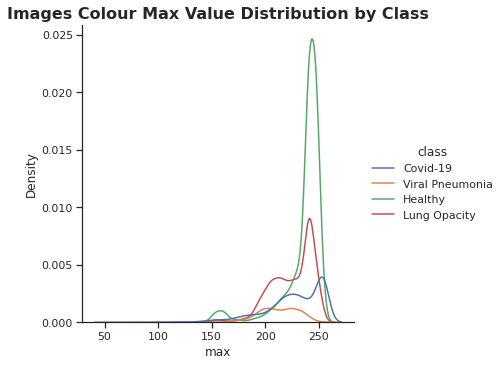

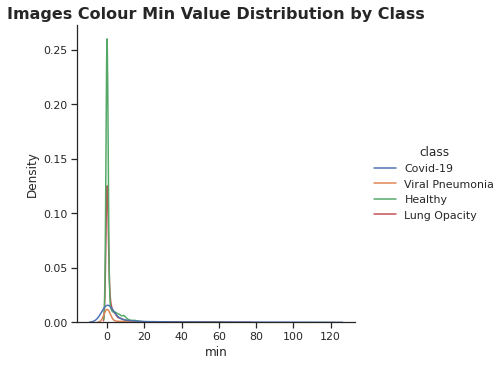

In [ ]:
ax = sns.displot(data=image_eda, x = 'mean', kind='kde')
plt.title('Images Colour Mean Value Distribution', fontsize = 16, weight='bold')

ax = sns.displot(data=image_eda, x = 'mean', kind='kde', hue='class')
plt.title('Images Colour Mean Value Distribution by Class', fontsize = 16, weight='bold')

ax = sns.displot(data=image_eda, x = 'max', kind='kde', hue='class')
plt.title('Images Colour Max Value Distribution by Class', fontsize = 16, weight='bold')

ax = sns.displot(data=image_eda, x = 'min', kind='kde', hue='class')
plt.title('Images Colour Min Value Distribution by Class', fontsize = 16, weight='bold')

### From the graphs:

1. Mean:
    - They are at peak at:
    - Healthy (\~110 + \~160), Lung Opacity (\~110), Covid19 (\~150), Viral (\~130)
2. Max:
    - Covid19 and Lung Opacity has quite similar pattern (the 'bumps')
    - All has peak around 250 except viral
3. Min:
    - All has peak around 0

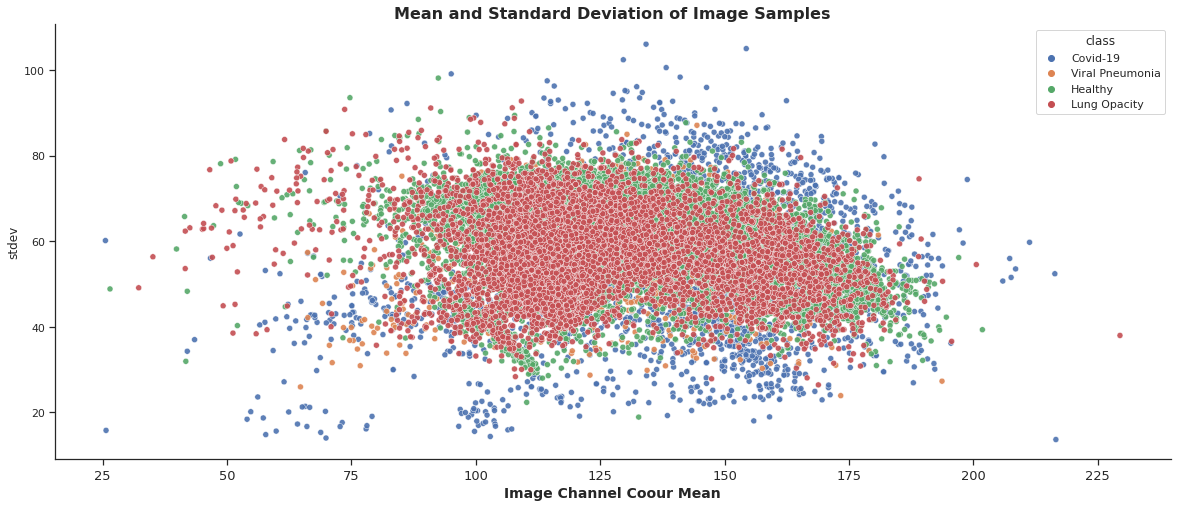

In [ ]:
#Let's visualize between the mean and std of each class.

plt.figure(figsize=(20,8))
sns.set(style='ticks', font_scale = 1)
ax = sns.scatterplot(data=image_eda, x='mean', y='stdev', 
                    hue='class', alpha=0.9)
sns.despine(top=True, right=True)
plt.xticks(rotation=0, fontsize=13)
ax.set_xlabel('Image Channel Coour Mean', fontsize=14, weight='bold')
plt.title('Mean and Standard Deviation of Image Samples', fontsize=16, weight='bold')
pass

## Insights from the graph:
- most of the plot focus in the central.
- covid19 class seems to have lower standard deviation compared to other class.
- the plot is abit messy and we can observe that there's some potential outliers.

<Figure size 1440x576 with 0 Axes>

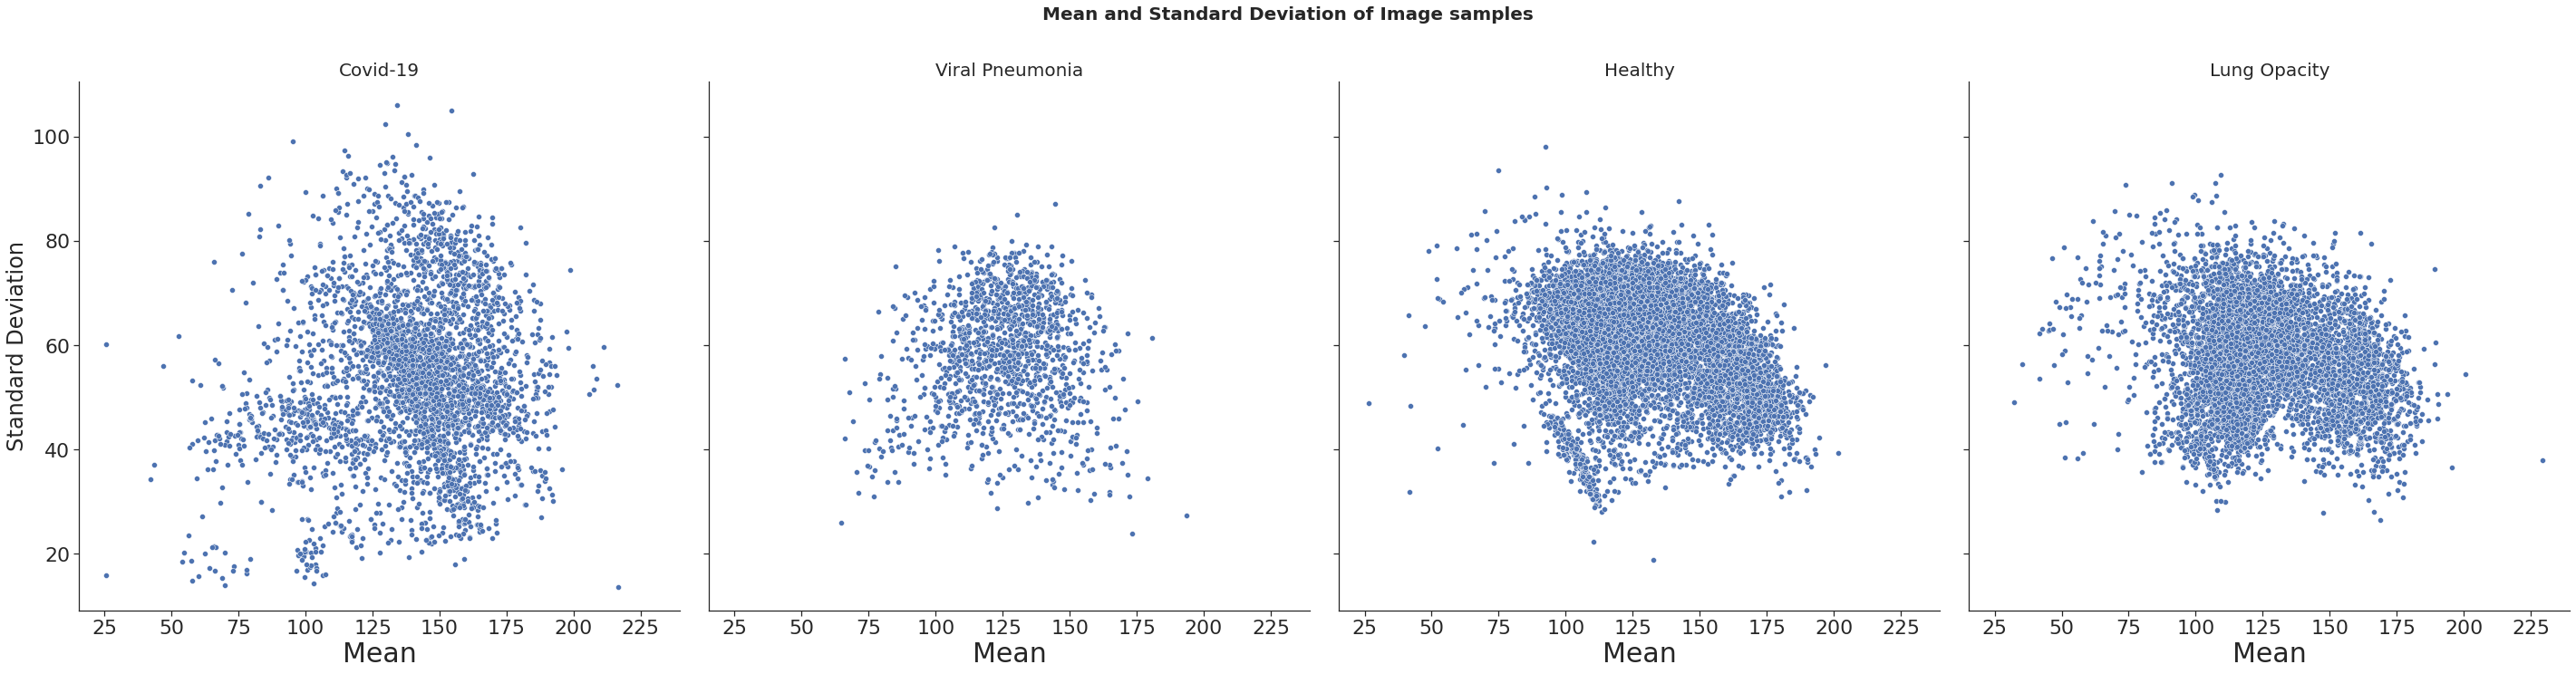

In [ ]:
#Let's analyse separately.

plt.figure(figsize=(20,8))
sns.set(style='ticks', font_scale = 2)
g = sns.FacetGrid(image_eda, col='class', height=10)
g.map_dataframe(sns.scatterplot, x='mean', y='stdev')
g.set_titles(col_template='{col_name}', row_template='{row_name}', size=20)
g.fig.subplots_adjust(top=.8)
g.fig.suptitle('Mean and Standard Deviation of Image samples', fontsize=20, weight='bold', y= 1.05)
axes = g.axes.flatten()
axes[0].set_ylabel('Standard Deviation')

for ax in axes:
    ax.set_xlabel('Mean', size=30)
g.fig.tight_layout()

## Insights from graph:
- covid19 class has scattered more around the graph. May indicate that the data has high distinction.
- lung opacity and healthy seems to have similar pattern, and has a trend of higher std with lower mean, higher mean with lower std
- viral pneumonia has more concentrated plots. May indicate that the data has higher similarity.

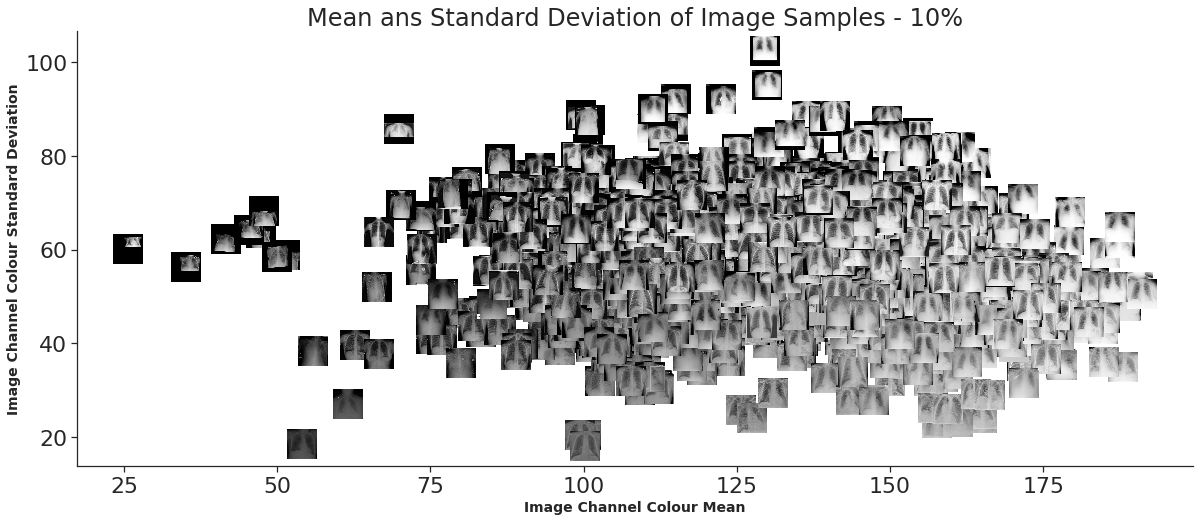

In [ ]:
#Let's visualize via images

def get_image(path):
    return OffsetImage(cv2.imread(path), zoom =0.1) #offsetimage to let it plot in graph

df_sample = image_eda.sample(frac=0.1, replace=False, random_state=1)
paths = df_sample['image_path']

fig, ax = plt.subplots(figsize=(20,8))
ab = sns.scatterplot(data=df_sample, x='mean', y='stdev')
sns.despine(top=True, right=True)
ax.set_xlabel('Image Channel Colour Mean', fontsize=14, weight='bold')
ax.set_ylabel('Image Channel Colour Standard Deviation', fontsize=14, weight='bold')
plt.title('Mean ans Standard Deviation of Image Samples - 10%')

for x0, y0, path in zip(df_sample['mean'], df_sample['stdev'], paths):
    abc = AnnotationBbox(get_image(path), (x0,y0), frameon=False)
    ax.add_artist(abc)

## Insights from graph:
- Higher std = higher contrast
- Higher mean = brighter image.
- Lower mean due to black background.

## Visualizing functions

In [139]:
def print_info(test_gen, preds, verbose):
    '''
    Takes in test_set, predictions, verbose, 
    '''
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames 
    
    
    new_dict={}
    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}
    # store new_dict as a text fine in the save_dir
    
    classes=list(class_dict.keys())     # list of string of class names
    
    errors=0      
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    error_indices=[]
    y_pred=[]
    
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)              
        true_index=labels[i]  # labels are integer values
        
        y_pred.append(pred_index) 
        
        if pred_index != true_index: # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index]) #keep track how much confident of the correct one
            error_indices.append(true_index)            
            errors=errors + 1

    if verbose !=0:
        if errors>0:
            if verbose>errors:
                r=errors
            else:
                r=print_code           
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print(msg)
            for i in range(r):                
                split1=os.path.split(error_list[i])                
                split2=os.path.split(split1[0])                
                fname=split2[1] + '/' + split1[1]
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i],true_class[i], ' ', prob_list[i])
                print(msg)
                #print(error_list[i]  , pred_class[i], true_class[i], prob_list[i])               
        else:
            print('With accuracy of 100 % there are no errors to print')

    if errors>0:
        plot_bar=[]
        plot_class=[]
        
        for key, value in new_dict.items():        
            count=error_indices.count(key) 
            if count>0:
                plot_bar.append(count) # list containg how many times a class had an error
                plot_class.append(value)   # stores the class 
                
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        
        plt.style.use('fivethirtyeight')
        
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x)
            plt.title('Errors by Class on Test Set')
            
    y_true= np.array(labels)        
    y_pred= np.array(y_pred)
    
    if len(classes)<= 10: #in our case, only 4 classes
        # create a confusion matrix 
        cm = confusion_matrix(y_true, y_pred )        
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
        
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)

In [140]:
#plot the model performance:
def tr_plot(tr_data, start_epoch):
    
    #Plot the training and validation data
    tacc = tr_data.history['accuracy']
    tloss = tr_data.history['loss']
    vacc = tr_data.history['val_accuracy']
    vloss = tr_data.history['val_loss']
    
    epoch_count=len(tacc)+ start_epoch
    epochs= list(range(start_epoch+1, epoch_count+1))
        
    index_loss=np.argmin(vloss) #this is the epoch with the lowest validation loss
    index_acc=np.argmax(vacc) #this is the epoch with the highest acc
        
    val_lowest = vloss[np.argmin(vloss)] 
    acc_highest=vacc[np.argmax(vacc)]
    
    sc_label='best epoch= '+ str(index_loss + start_epoch + 1) #start from 1
    vc_label='best epoch= '+ str(index_acc + start_epoch + 1) #start from 1
    
    plt.style.use('fivethirtyeight')

    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    
    axes[0].plot(epochs,tloss,'r', label='Training loss')
    axes[0].plot(epochs,vloss,'g', label='Validation loss')
    axes[0].scatter(index_loss + start_epoch,val_lowest + 1, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    
    axes[1].plot (epochs,tacc,'r', label= 'Training Accuracy')
    axes[1].plot (epochs,vacc,'g', label= 'Validation Accuracy')
    axes[1].scatter(index_acc + start_epoch,acc_highest + 1, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    
    plt.tight_layout
    plt.show()

In [141]:
#Plot training and validation Loss
def plot_tv_loss(history):
    fig, axarr = plt.subplots(1,3, figsize=(15,5),sharex=True)

    sns.set(style="ticks", font_scale = 1)
    sns.despine(top=True, right=True, left=False, bottom=False)

    recall_text = list(history.history.keys())[2]
    val_recall_text = list(history.history.keys())[5]

    historyDF = pd.DataFrame.from_dict(history.history)
    ax = sns.lineplot(x =historyDF.index, y = history.history[recall_text],ax=axarr[0],label="Training");
    ax = sns.lineplot(x =historyDF.index, y = history.history[val_recall_text],ax=axarr[0],label="Validation");
    ax.set_ylabel('Recall')
    ax = sns.lineplot(x =historyDF.index, y = history.history['loss'],ax=axarr[1],label="Training");
    ax = sns.lineplot(x =historyDF.index, y = history.history['val_loss'],ax=axarr[1],label="Validation");
    ax.set_ylabel('Loss')
    ax = sns.lineplot(x =historyDF.index, y = history.history['lr'],ax=axarr[2]);
    ax.set_ylabel('Learning Rate')    
    axarr[0].set_title("Training and Validation Set - Metric Recall")
    axarr[1].set_title("Training and Validation Set - Loss")
    axarr[2].set_title("Learning Rate during Training")

    for ax in axarr:
        ax.set_xlabel('Epochs')
        
    plt.suptitle('Training Performance Plots',fontsize=16, weight = 'bold');
    fig.tight_layout(pad=3.0)      
    plt.show()

# Modelling

In [7]:
#now let's sample out data for CNN model.

covid_data = covid_df[['image_path','class']]
covid_data = covid_data.groupby('class').apply(lambda grp: grp.sample(n=1200)).reset_index(level=[0, 1], drop=True)
covid_data = covid_data.sample(frac=1, random_state=42) #shuffle

## Self-build CNN + DenseNet169

### Self-build CNN

In [174]:
path = '/content/drive/MyDrive/Assignment - Covid 19 Radiography Data/dataset' #drive
classes = list(covid_data['class'].unique())
num_classes = len(classes)

batch_size=16

#augment
train_datagen = ImageDataGenerator(rescale=1/255, rotation_range=20, 
                                   width_shift_range=0.2, height_shift_range=0.2,
                                   horizontal_flip=True, validation_split=0.2)

#no augment
test_datagen = ImageDataGenerator(rescale=1/255, validation_split=0.2)

'''
In your case, the problem with setting the shuffle=True is that if you shuffle on your validation set, 
the results will be chaotic. It happens that the prediction is correct but compared to wrong indices can 
lead to misleading results, just like it happened in your case.

Always shuffle=True on the training set and shuffle=False on the validation set and test set.
'''

#loading in!
train_gen = train_datagen.flow_from_dataframe(dataframe=covid_data,
                                              directory=path, 
                                              target_size=(299,299),
                                              x_col='image_path',
                                              y_col='class',
                                              batch_size=batch_size, 
                                              seed=42, 
                                              class_mode='categorical',
                                              subset='training', #can pass here because above use validation_split 
                                              shuffle=True, 
                                              color_mode='rgb')

test_gen = test_datagen.flow_from_dataframe(dataframe=covid_data,
                                              directory=path, 
                                              target_size=(299,299),
                                              x_col='image_path',
                                              y_col='class',
                                              batch_size=batch_size, 
                                              seed=42, 
                                              class_mode='categorical',
                                              subset='validation', #can pass here because above use validation_split 
                                              shuffle=False, 
                                              color_mode='rgb')

Found 3840 validated image filenames belonging to 4 classes.
Found 960 validated image filenames belonging to 4 classes.


In [109]:
#Let's see the generated images.
def show_image_samples(gen):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 

    plt.figure(figsize=(20, 20))
    length=len(labels)

    for i in range(batch_size):
        plt.subplot(4, 4, i + 1)
        image=images[i][:,:,0]
        plt.imshow(image, cmap='gray')
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=12)
        plt.axis('off')
    plt.show()

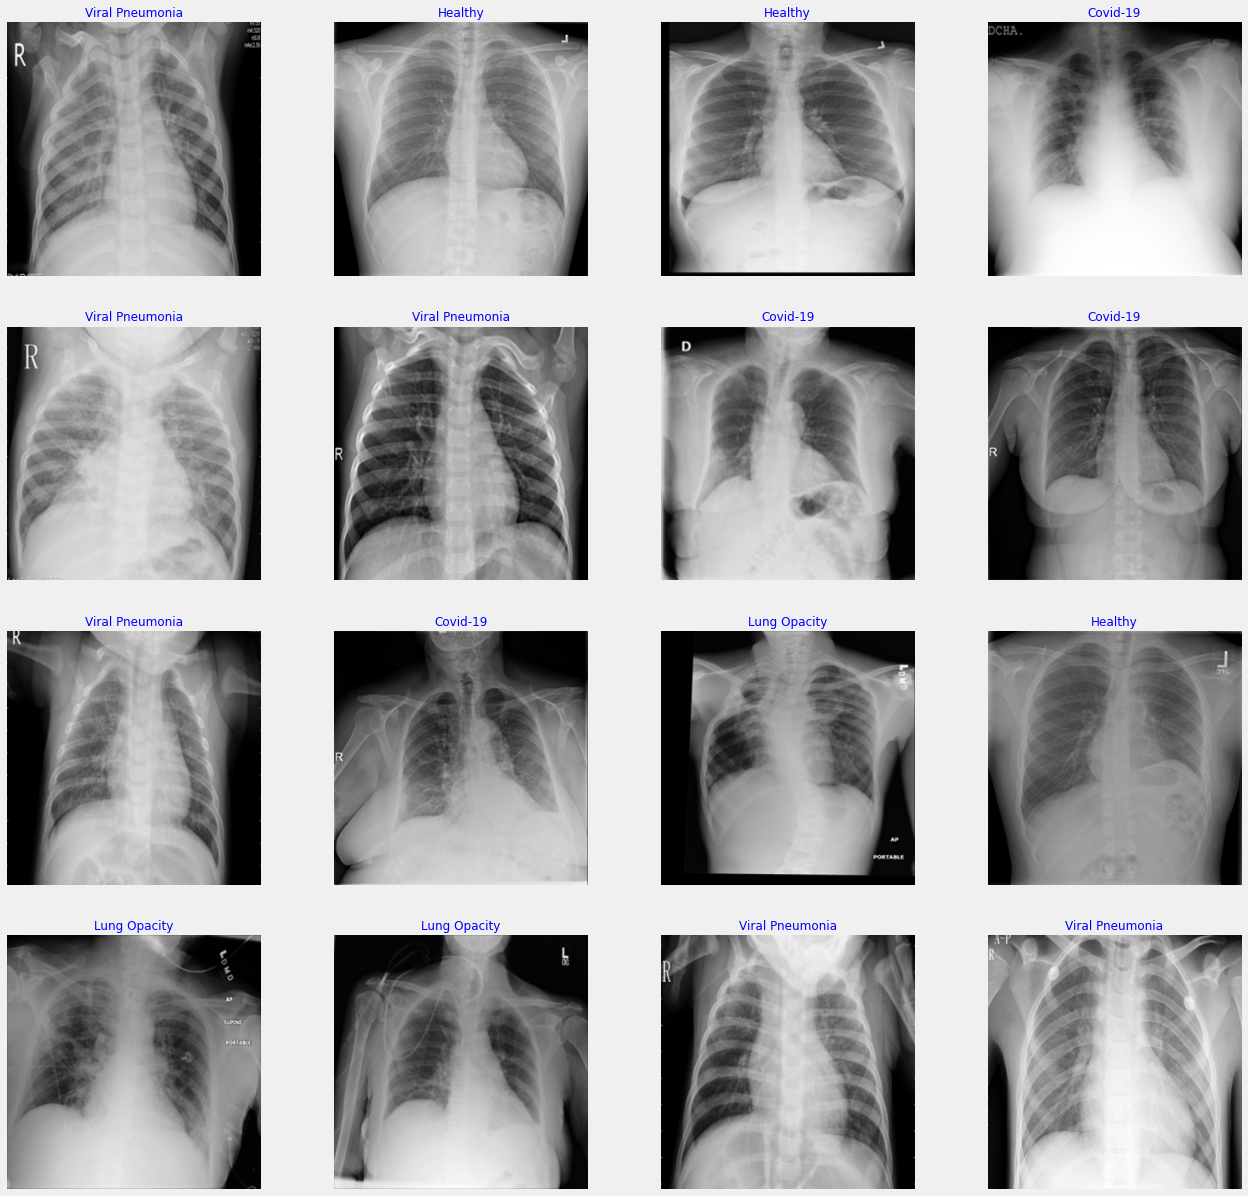

In [110]:
show_image_samples(test_gen)

In [175]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=(299, 299, 3)))
model.add(BatchNormalization())
##############################
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
##############################
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
##############################
model.add(Flatten())

model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(Activation('relu'))
model.add(Dropout(0.25))

#Output
model.add(BatchNormalization())
model.add(Dense(num_classes, activation='softmax'))

In [176]:
#Compile the model
opt = Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.01, amsgrad=False)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy', Recall()])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [177]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_35 (Conv2D)          (None, 299, 299, 32)      896       
                                                                 
 batch_normalization_54 (Bat  (None, 299, 299, 32)     128       
 chNormalization)                                                
                                                                 
 conv2d_36 (Conv2D)          (None, 299, 299, 64)      18496     
                                                                 
 batch_normalization_55 (Bat  (None, 299, 299, 64)     256       
 chNormalization)                                                
                                                                 
 average_pooling2d_24 (Avera  (None, 149, 149, 64)     0         
 gePooling2D)                                                    
                                                      

In [178]:
#Model Parameters
epochs = 60

#Callbacks
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=10, verbose=0, factor=0.5, min_lr=0.00001)
early_stopping_monitor = EarlyStopping(patience=100,monitor='val_loss', mode = 'min',verbose=0)

callbacks_list = [learning_rate_reduction,early_stopping_monitor]

#Verbose set to 1
history = model.fit(train_gen, steps_per_epoch=len(train_gen) // batch_size, 
                    validation_steps=len(test_gen) // batch_size, 
                    validation_data=test_gen, epochs=epochs,callbacks=[callbacks_list],
                    verbose=1)

#Predict Results on test set
y_pred = model.predict(test_gen)

Epoch 1/60
15/15 [==============================] - 11s 550ms/step - loss: 1.8670 - accuracy: 0.4042 - recall_14: 0.3667 - val_loss: 7.2196 - val_accuracy: 0.1667 - val_recall_14: 0.1667 - lr: 0.0020
Epoch 2/60
15/15 [==============================] - 8s 515ms/step - loss: 1.4710 - accuracy: 0.4208 - recall_14: 0.3542 - val_loss: 5.3141 - val_accuracy: 0.2917 - val_recall_14: 0.2917 - lr: 0.0020
Epoch 3/60
15/15 [==============================] - 8s 513ms/step - loss: 1.3219 - accuracy: 0.4875 - recall_14: 0.4125 - val_loss: 4.7714 - val_accuracy: 0.1875 - val_recall_14: 0.1250 - lr: 0.0020
Epoch 4/60
15/15 [==============================] - 8s 517ms/step - loss: 1.1440 - accuracy: 0.5125 - recall_14: 0.4250 - val_loss: 1.3199 - val_accuracy: 0.3750 - val_recall_14: 0.3125 - lr: 0.0020
Epoch 5/60
15/15 [==============================] - 8s 515ms/step - loss: 1.2920 - accuracy: 0.4875 - recall_14: 0.4125 - val_loss: 1.6241 - val_accuracy: 0.4167 - val_recall_14: 0.3125 - lr: 0.0020
Epoc

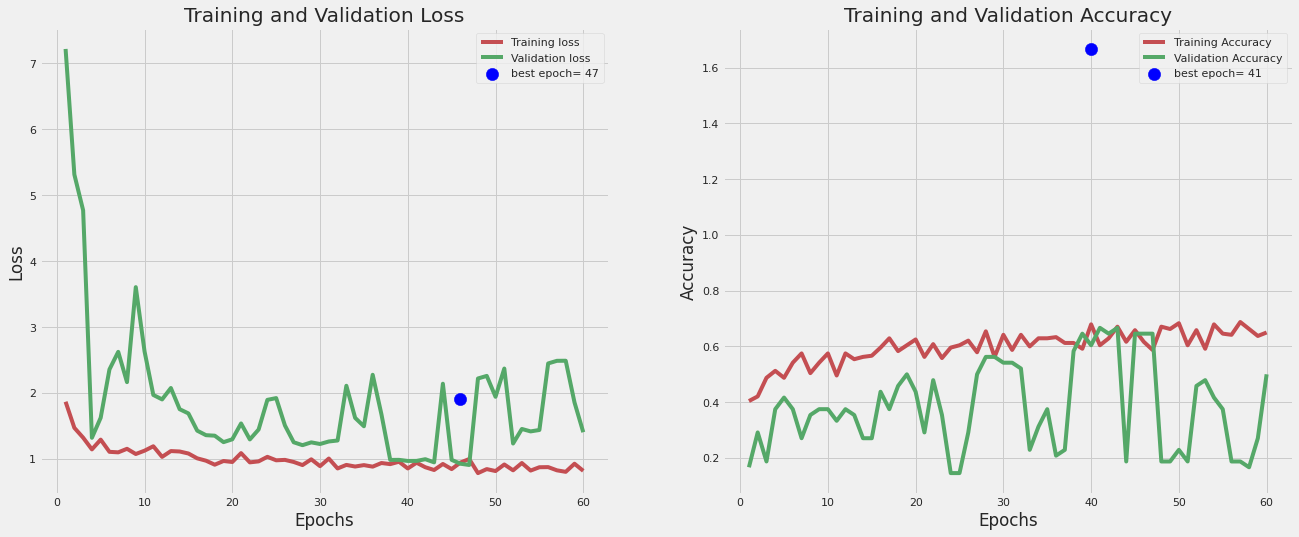

In [179]:
tr_plot(history, 0)

In [121]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'recall_10', 'val_loss', 'val_accuracy', 'val_recall_10', 'lr'])

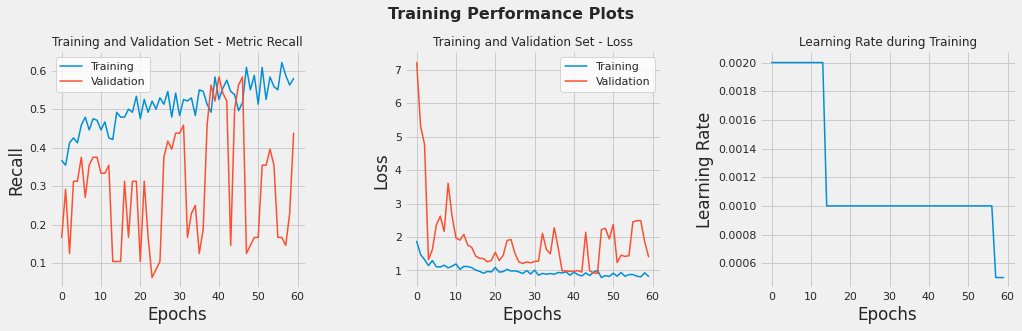

In [180]:
plot_tv_loss(history)

          Filename                Predicted Class                True Class           Probability   
Lung_Opacity/Lung_Opacity-1790.png          Covid-19                  Lung Opacity            0.5724


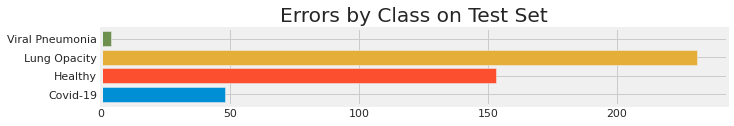

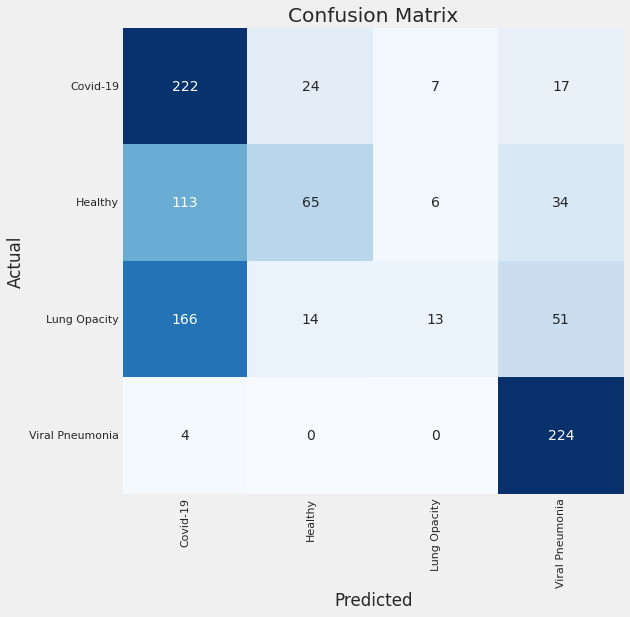

Classification Report:
----------------------
                  precision    recall  f1-score   support

       Covid-19       0.44      0.82      0.57       270
        Healthy       0.63      0.30      0.40       218
   Lung Opacity       0.50      0.05      0.10       244
Viral Pneumonia       0.69      0.98      0.81       228

       accuracy                           0.55       960
      macro avg       0.56      0.54      0.47       960
   weighted avg       0.56      0.55      0.47       960



In [181]:
#Predict Results on test set
y_pred = model.predict(test_gen)
print_info(test_gen, y_pred, verbose=1)

In [182]:
# Save the entire model as a SavedModel.
model.save('/content/drive/MyDrive/Assignment - Covid 19 Radiography Data/self_cnn_1pm_12april.h5')

# Recreate the exact same model, including its weights and the optimizer
# new_model = tf.keras.models.load_model('self_cnn_1pm_12april.h5')

#CONCLUSION - SELF BUILD IS NOT GOOD

### Densenet 169

In [183]:
#use pre-train CNN

# load the DenseNet169 network, ensuring the head FC layer sets are left off
base_model = tf.keras.applications.densenet.DenseNet169(include_top=False, weights='imagenet', input_tensor=Input(shape=(299, 299, 3)))

#follow
headModel = base_model.output
headModel = AveragePooling2D(pool_size=(4, 4), strides=1)(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(512, activation="relu")(headModel)
headModel = BatchNormalization()(headModel)
headModel = Dropout(0.2)(headModel)
headModel = Dense(4, activation="softmax")(headModel)

# loop over all layers in the base model and set them as not trainable
for layer in base_model.layers:
    layer.trainable = False

# place the head FC model on top of the base model
model = Model(inputs=base_model.input, outputs=headModel)

model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_10 (ZeroPadding  (None, 305, 305, 3)  0          ['input_11[0][0]']               
 2D)                                                                                              
                                                                                                  
 conv1/conv (Conv2D)            (None, 150, 150, 64  9408        ['zero_padding2d_10[0][0]']      
                                )                                                           

In [184]:
# initialize the learning rate, epochs and batch size to train the model
learning_rate = 0.001
epochs = 20
bs = 16

# initialize the optimizer 
optimizer = Adam(learning_rate= learning_rate, decay=learning_rate/epochs)

# complie the model
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy', Recall()])

# start training the model
#Verbose set to 1
history_2 = model.fit(train_gen, steps_per_epoch=len(train_gen) // batch_size, 
                    validation_steps=len(test_gen) // batch_size, 
                    validation_data=test_gen, epochs=epochs,callbacks=[callbacks_list],
                    verbose=1)

Epoch 1/20
15/15 [==============================] - 22s 737ms/step - loss: 1.2374 - accuracy: 0.6375 - recall_15: 0.6292 - val_loss: 8.1683 - val_accuracy: 0.5000 - val_recall_15: 0.5000 - lr: 0.0010
Epoch 2/20
15/15 [==============================] - 8s 504ms/step - loss: 0.9243 - accuracy: 0.7125 - recall_15: 0.6917 - val_loss: 1.6426 - val_accuracy: 0.6667 - val_recall_15: 0.6667 - lr: 0.0010
Epoch 3/20
15/15 [==============================] - 8s 502ms/step - loss: 0.7068 - accuracy: 0.7292 - recall_15: 0.7125 - val_loss: 1.2363 - val_accuracy: 0.7292 - val_recall_15: 0.7292 - lr: 0.0010
Epoch 4/20
15/15 [==============================] - 8s 507ms/step - loss: 0.6557 - accuracy: 0.7292 - recall_15: 0.6917 - val_loss: 2.3937 - val_accuracy: 0.5833 - val_recall_15: 0.5833 - lr: 0.0010
Epoch 5/20
15/15 [==============================] - 8s 506ms/step - loss: 0.7450 - accuracy: 0.7250 - recall_15: 0.6958 - val_loss: 1.1879 - val_accuracy: 0.7083 - val_recall_15: 0.7083 - lr: 0.0010
Epoc

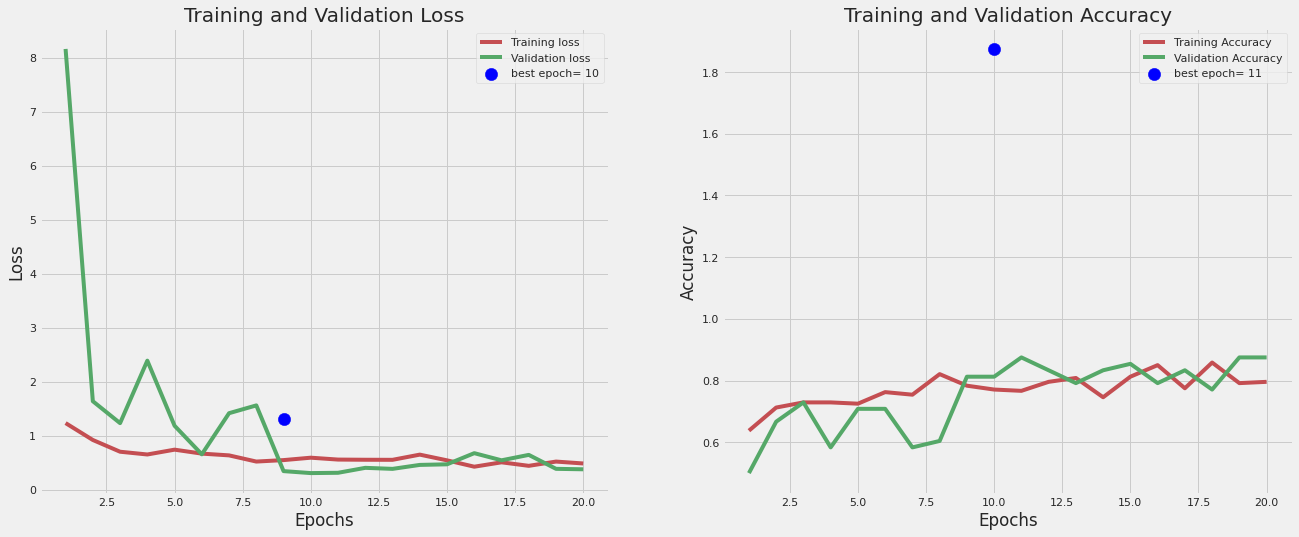

In [185]:
tr_plot(history_2, 0)

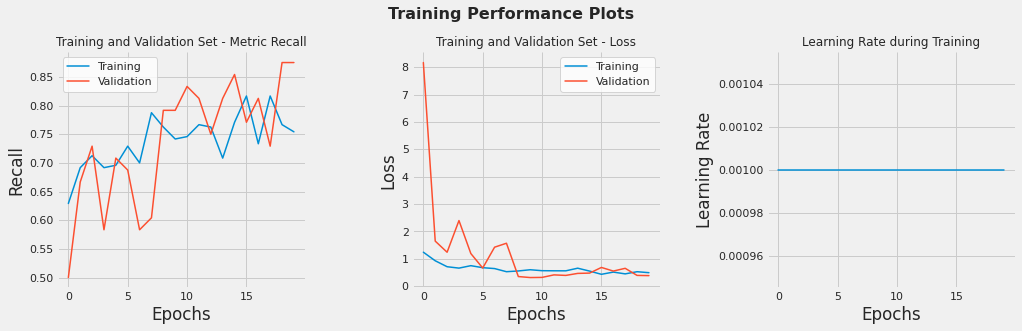

In [186]:
plot_tv_loss(history_2)

In [188]:
#Predict Results on test set
y_pred = model.predict(test_gen)

          Filename                Predicted Class                True Class           Probability   
    COVID/COVID-1960.png            Lung Opacity                  Covid-19              0.7513


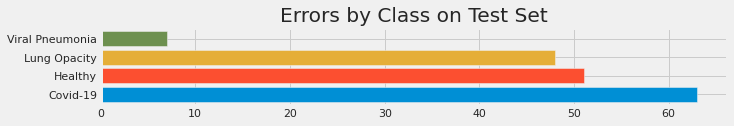

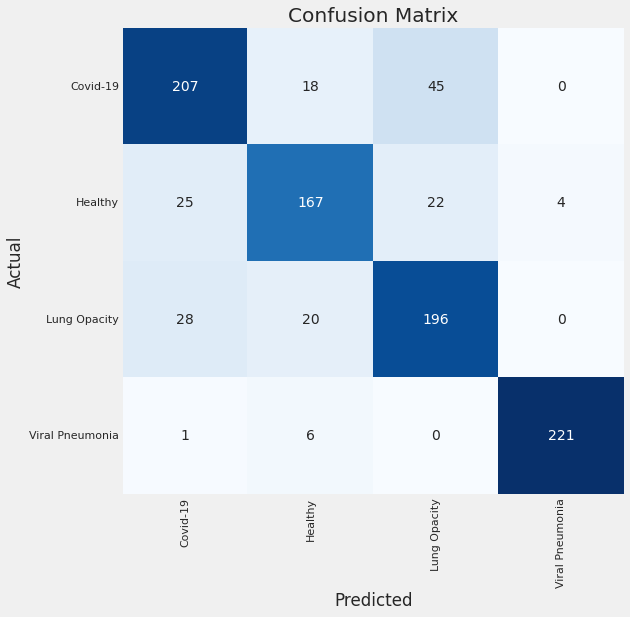

Classification Report:
----------------------
                  precision    recall  f1-score   support

       Covid-19       0.79      0.77      0.78       270
        Healthy       0.79      0.77      0.78       218
   Lung Opacity       0.75      0.80      0.77       244
Viral Pneumonia       0.98      0.97      0.98       228

       accuracy                           0.82       960
      macro avg       0.83      0.83      0.83       960
   weighted avg       0.83      0.82      0.82       960



In [189]:
print_info(test_gen, y_pred, verbose=1)

In [190]:
# Save the entire model as a SavedModel.
model.save('/content/drive/MyDrive/Assignment - Covid 19 Radiography Data/densenet169_cnn_4pm_12april.h5')

# Recreate the exact same model, including its weights and the optimizer
# new_model = tf.keras.models.load_model('self_cnn_1pm_12april.h5')

#CONCLUSION - DENSENET GOOD

## EfficientNetB3

In [8]:
path = '/content/drive/MyDrive/Assignment - Covid 19 Radiography Data/dataset' #drive
classes = list(covid_data['class'].unique())
num_classes = len(classes)

batch_size=16

#augment
# EfficientNet expects pixelsin range 0 to 255 so no scaling is required
train_datagen = ImageDataGenerator(rotation_range=20, 
                                   width_shift_range=0.2, height_shift_range=0.2,
                                   horizontal_flip=True, validation_split=0.2)

#no augment
test_datagen = ImageDataGenerator(validation_split=0.2)

#loading in!
train_gen = train_datagen.flow_from_dataframe(dataframe=covid_data,
                                              directory=path, 
                                              target_size=(299,299),
                                              x_col='image_path',
                                              y_col='class',
                                              batch_size=batch_size, 
                                              seed=42, 
                                              class_mode='categorical',
                                              subset='training', #can pass here because above use validation_split 
                                              shuffle=True, 
                                              color_mode='rgb')

test_gen = test_datagen.flow_from_dataframe(dataframe=covid_data,
                                              directory=path, 
                                              target_size=(299,299),
                                              x_col='image_path',
                                              y_col='class',
                                              batch_size=batch_size, 
                                              seed=42, 
                                              class_mode='categorical',
                                              subset='validation', #can pass here because above use validation_split 
                                              shuffle=False, #
                                              color_mode='rgb')

Found 3840 validated image filenames belonging to 4 classes.
Found 960 validated image filenames belonging to 4 classes.


In [192]:
model_name='EfficientNetB3'
base_model=tf.keras.applications.EfficientNetB3(include_top=False, weights="imagenet",input_shape=(299,299,3), pooling='max') 
x=base_model.output
x=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.45, seed=123)(x)        
output=Dense(4, activation='softmax')(x)

In [193]:
# initialize the learning rate, epochs and batch size to train the model
learning_rate = 0.001
epochs = 40
bs = 16

model=Model(inputs=base_model.input, outputs=output)
model.compile(Adamax(learning_rate=.001), loss='categorical_crossentropy', metrics=['accuracy', Recall()]) 

history_3 = model.fit(train_gen, steps_per_epoch=len(train_gen) // batch_size, 
                      validation_steps=len(test_gen) // batch_size, 
                      validation_data=test_gen, epochs=epochs,callbacks=[callbacks_list],
                      verbose=1)

Epoch 1/40
15/15 [==============================] - 38s 1s/step - loss: 9.1715 - accuracy: 0.5000 - recall_16: 0.4583 - val_loss: 14.8071 - val_accuracy: 0.3958 - val_recall_16: 0.3958 - lr: 0.0010
Epoch 2/40
15/15 [==============================] - 17s 1s/step - loss: 8.7377 - accuracy: 0.5917 - recall_16: 0.5583 - val_loss: 10.0523 - val_accuracy: 0.6667 - val_recall_16: 0.6458 - lr: 0.0010
Epoch 3/40
15/15 [==============================] - 18s 1s/step - loss: 8.1112 - accuracy: 0.6750 - recall_16: 0.6500 - val_loss: 10.1073 - val_accuracy: 0.5833 - val_recall_16: 0.5208 - lr: 0.0010
Epoch 4/40
15/15 [==============================] - 18s 1s/step - loss: 7.8936 - accuracy: 0.7083 - recall_16: 0.6917 - val_loss: 9.1571 - val_accuracy: 0.6250 - val_recall_16: 0.6250 - lr: 0.0010
Epoch 5/40
15/15 [==============================] - 18s 1s/step - loss: 7.5073 - accuracy: 0.7625 - recall_16: 0.7083 - val_loss: 8.3298 - val_accuracy: 0.6458 - val_recall_16: 0.6250 - lr: 0.0010
Epoch 6/40
1

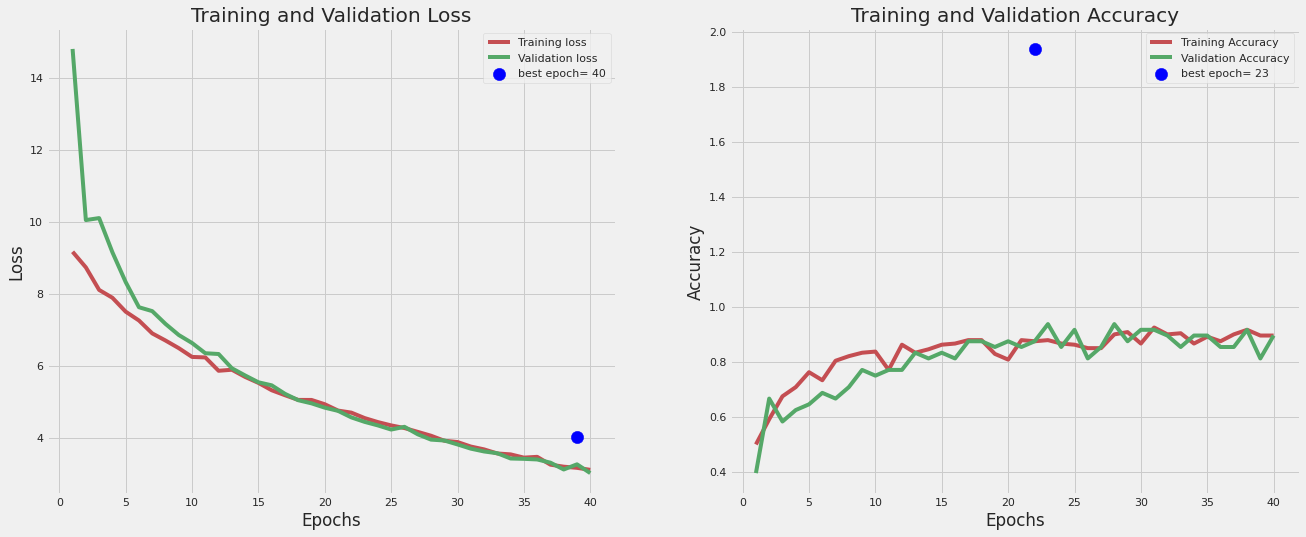

In [194]:
tr_plot(history_3, 0)

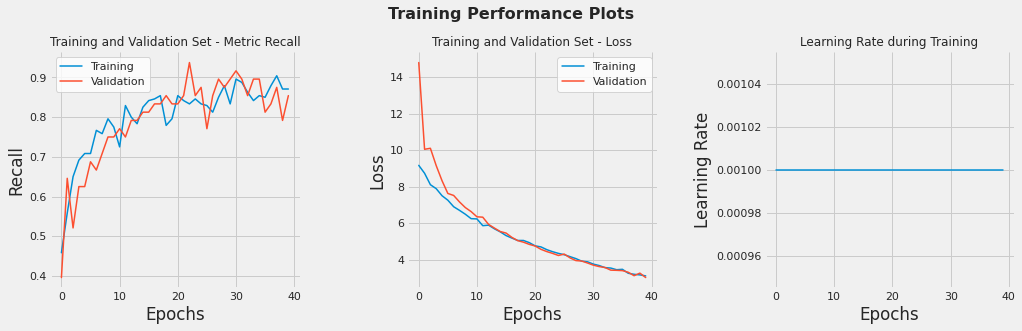

In [195]:
plot_tv_loss(history_3)

60/60 [==============================] - 15s 214ms/step
          Filename                Predicted Class                True Class           Probability   
Lung_Opacity/Lung_Opacity-2757.png          Healthy                   Lung Opacity            0.8706


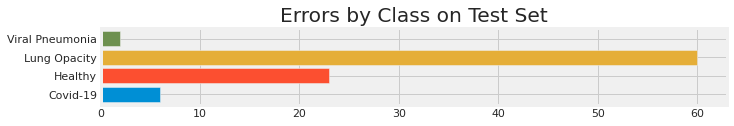

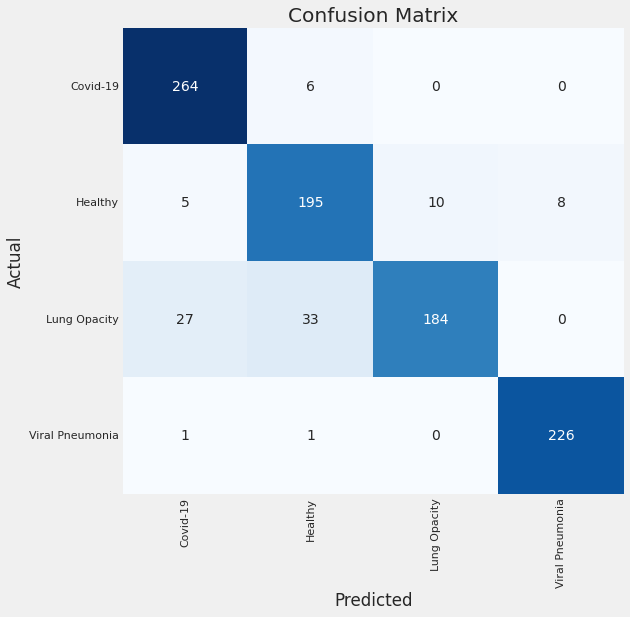

Classification Report:
----------------------
                  precision    recall  f1-score   support

       Covid-19       0.89      0.98      0.93       270
        Healthy       0.83      0.89      0.86       218
   Lung Opacity       0.95      0.75      0.84       244
Viral Pneumonia       0.97      0.99      0.98       228

       accuracy                           0.91       960
      macro avg       0.91      0.90      0.90       960
   weighted avg       0.91      0.91      0.90       960



In [196]:
#Predict Results on test set
# y_pred = model.predict(test_gen)
y_pred=model.predict(test_gen,verbose=1) 
print_info(test_gen, y_pred, verbose=1)

In [197]:
# Save the entire model as a SavedModel.
model.save('/content/drive/MyDrive/Assignment - Covid 19 Radiography Data/efficientnetb3_cnn_5pm_12april.h5')

# Recreate the exact same model, including its weights and the optimizer
# new_model = tf.keras.models.load_model('self_cnn_1pm_12april.h5')

#CONCLUSION - EFFICIENT NET IS THE BEST

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


# Summary (Average value)

*   EfficientNetB3 performed the best among the other 2 tested CNN models.




In [1]:
%%html
<iframe src="https://drive.google.com/file/d/1KlIMoCv7rlqSmYNIE9Fm_mWmYsY7hKqN/preview" width="640" height="480"></iframe>

In [9]:
# densenet169 = tf.keras.models.load_model('/content/drive/MyDrive/Assignment - Covid 19 Radiography Data/densenet169_cnn_4pm_12april.h5')
efficientnetb3 = tf.keras.models.load_model('/content/drive/MyDrive/Assignment - Covid 19 Radiography Data/efficientnetb3_cnn_5pm_12april.h5')
# self_cnn = tf.keras.models.load_model('/content/drive/MyDrive/Assignment - Covid 19 Radiography Data/self_cnn_1pm_12april.h5')

In [10]:
from tensorflow.keras.applications.efficientnet import preprocess_input as ef_preprocess

class_dict=test_gen.class_indices
reversed_dict = {}
for k, v in class_dict.items():
    reversed_dict[v] = k

In [14]:
def predictor(image_path, model):    
    
    img=cv2.imread(image_path)
    img=cv2.resize(img, (299,299))
    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
    img = tf.expand_dims(img, axis=0)
    img = ef_preprocess(img)


    preds=model.predict(img)    

    for i, p in enumerate(preds):
        index=np.argmax(p) # find the class index with the highest probability sum
        pred_class = reversed_dict[index]
        prob = p[index]

    #tf.squeeze(img)
    img=cv2.imread(image_path)
    return pred_class, prob, img

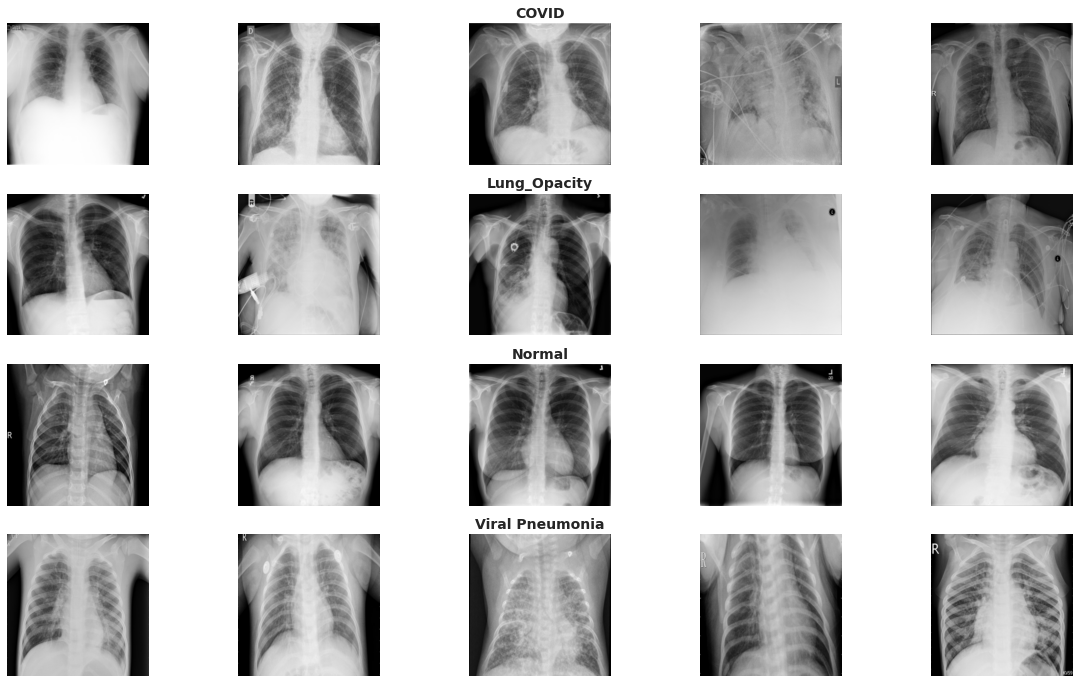

In [18]:
#ORI

#Image Sampling
n_samples = 5

#m_axs indicates how many rows
fig, m_axs = plt.subplots(4, n_samples, figsize = (4*n_samples, 3*4))

#group by each class
for n_axs, (class_name, class_rows) in zip(m_axs,covid_df.sort_values(['diagram']).groupby('diagram')):
    n_axs[2].set_title(class_name,fontsize = 14,weight = 'bold')
    
    #for each row/class, sample 5, and then show.
    for c_ax, (_, c_row) in zip(n_axs, class_rows.sample(n_samples, random_state=1224).iterrows()):       
        picture = c_row['image_path']
        image = cv2.imread(picture)
        c_ax.imshow(image)
        c_ax.axis('off')

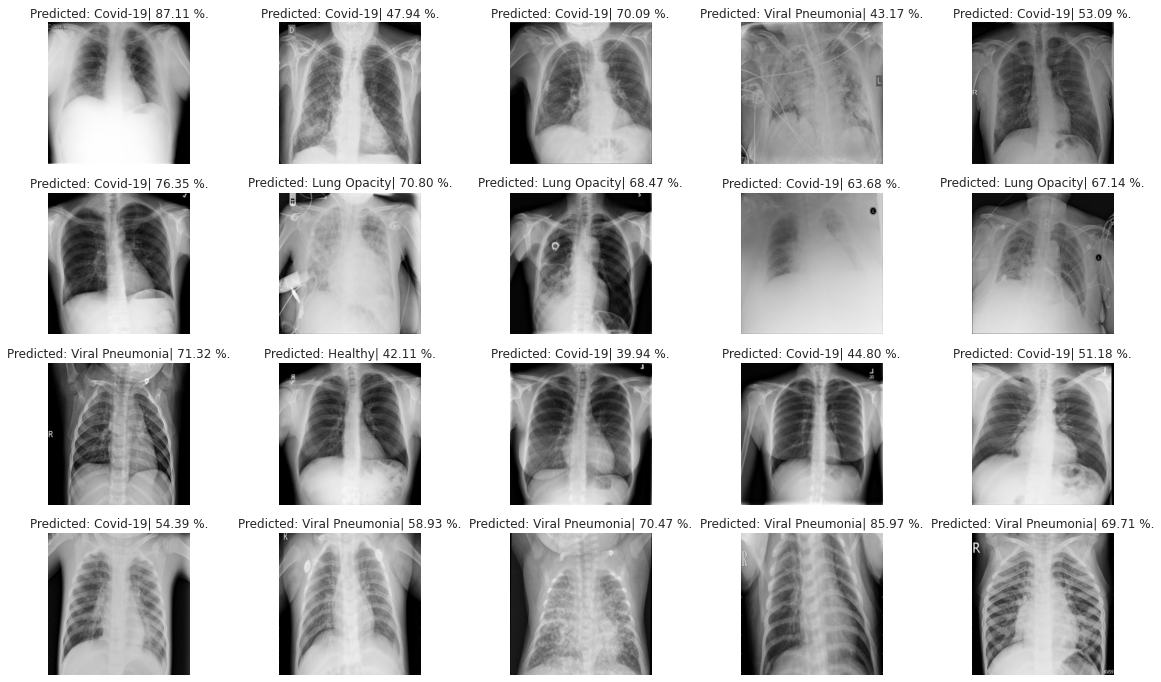

In [19]:
#PREDICTION

#m_axs indicates how many rows
fig, m_axs = plt.subplots(4, n_samples, figsize = (4*n_samples, 3*4))

#group by each class
for n_axs, (class_name, class_rows) in zip(m_axs,covid_df.sort_values(['diagram']).groupby('diagram')):
    # n_axs[2].set_title(class_name,fontsize = 14,weight = 'bold')
    
    #for each row/class, sample 5, and then show.
    for c_ax, (_, c_row) in zip(n_axs, class_rows.sample(n_samples, random_state=1224).iterrows()):       
        picture = c_row['image_path']
        image = cv2.imread(picture)
        c_ax.imshow(image)
        c_ax.axis('off')

        #make prediction
        pred_class, prob, _ = predictor(picture, efficientnetb3) # run the classifier
        c_ax.set_title(f'Predicted: {pred_class}|{prob * 100: 6.2f} %.', fontsize=12)

 image is of Healthy Xray with a probability of  94.27 %


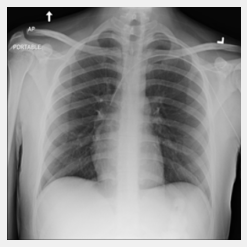

In [253]:
image_path = covid_data['image_path'][1202]
pred_class, prob, img = predictor(image_path, efficientnetb3) # run the classifier